<a href="https://colab.research.google.com/github/acucenarodrigues1998/TutorialPyBR2023-GenAINotebooks/blob/main/Tutorial_PyBR_04_Modelo_de_difusao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinando um Modelo de Difusão

## O que são modelos de difusão?

São modelos que funcionam em duas etapas:
1. **Forward Process**: destroem uma imagem, adicionando um ruído gradualmente.
2. **Parametrized Backward Process**: processo em que a imagem é recuperada, com o ruído sendo removido aos poucos, esse processo também é chamado de *Denoising*. Aqui, usamos uma rede neural para prever o ruído.

Então, o objetivo final do modelo de difusão é, a cada iteração, prever a quantidade de ruído que foi adicionada na imagem.

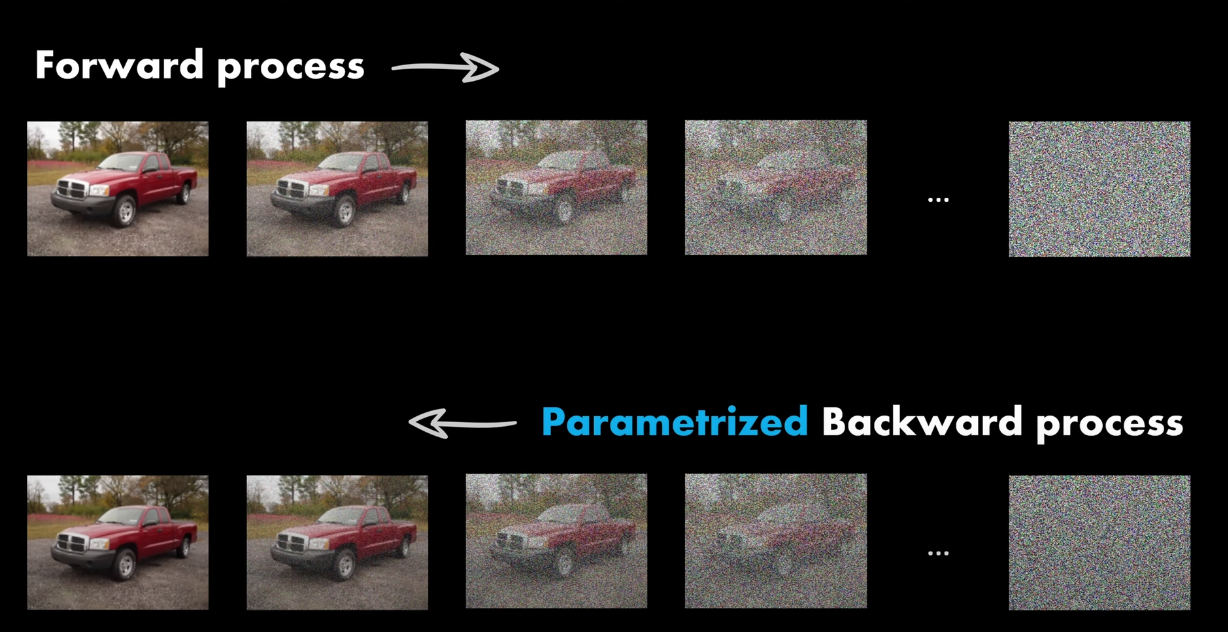

Para isso, vamos precisar de dois módulos:
1. **Noise Scheduler**: essa função fica responsável por pré-calcular todos os valores que precisamos para gerar e prever os ruídos a cada iteração no tempo.
2. **Rede Neural**: vamos utilizar uma versão simplificada da rede UNet, o formato da arquitetura dela pode ser vista na imagem abaixo, onde os retângulos em azul são blocos com:
- Conv2d
- BatchNorm2d
- LeakyReLU

Os retângulos em laranja e verde, o primeiro e último, respectivamente, são as camadas de input e output, que recebem uma imagem com três canais e devolvem os três canais.

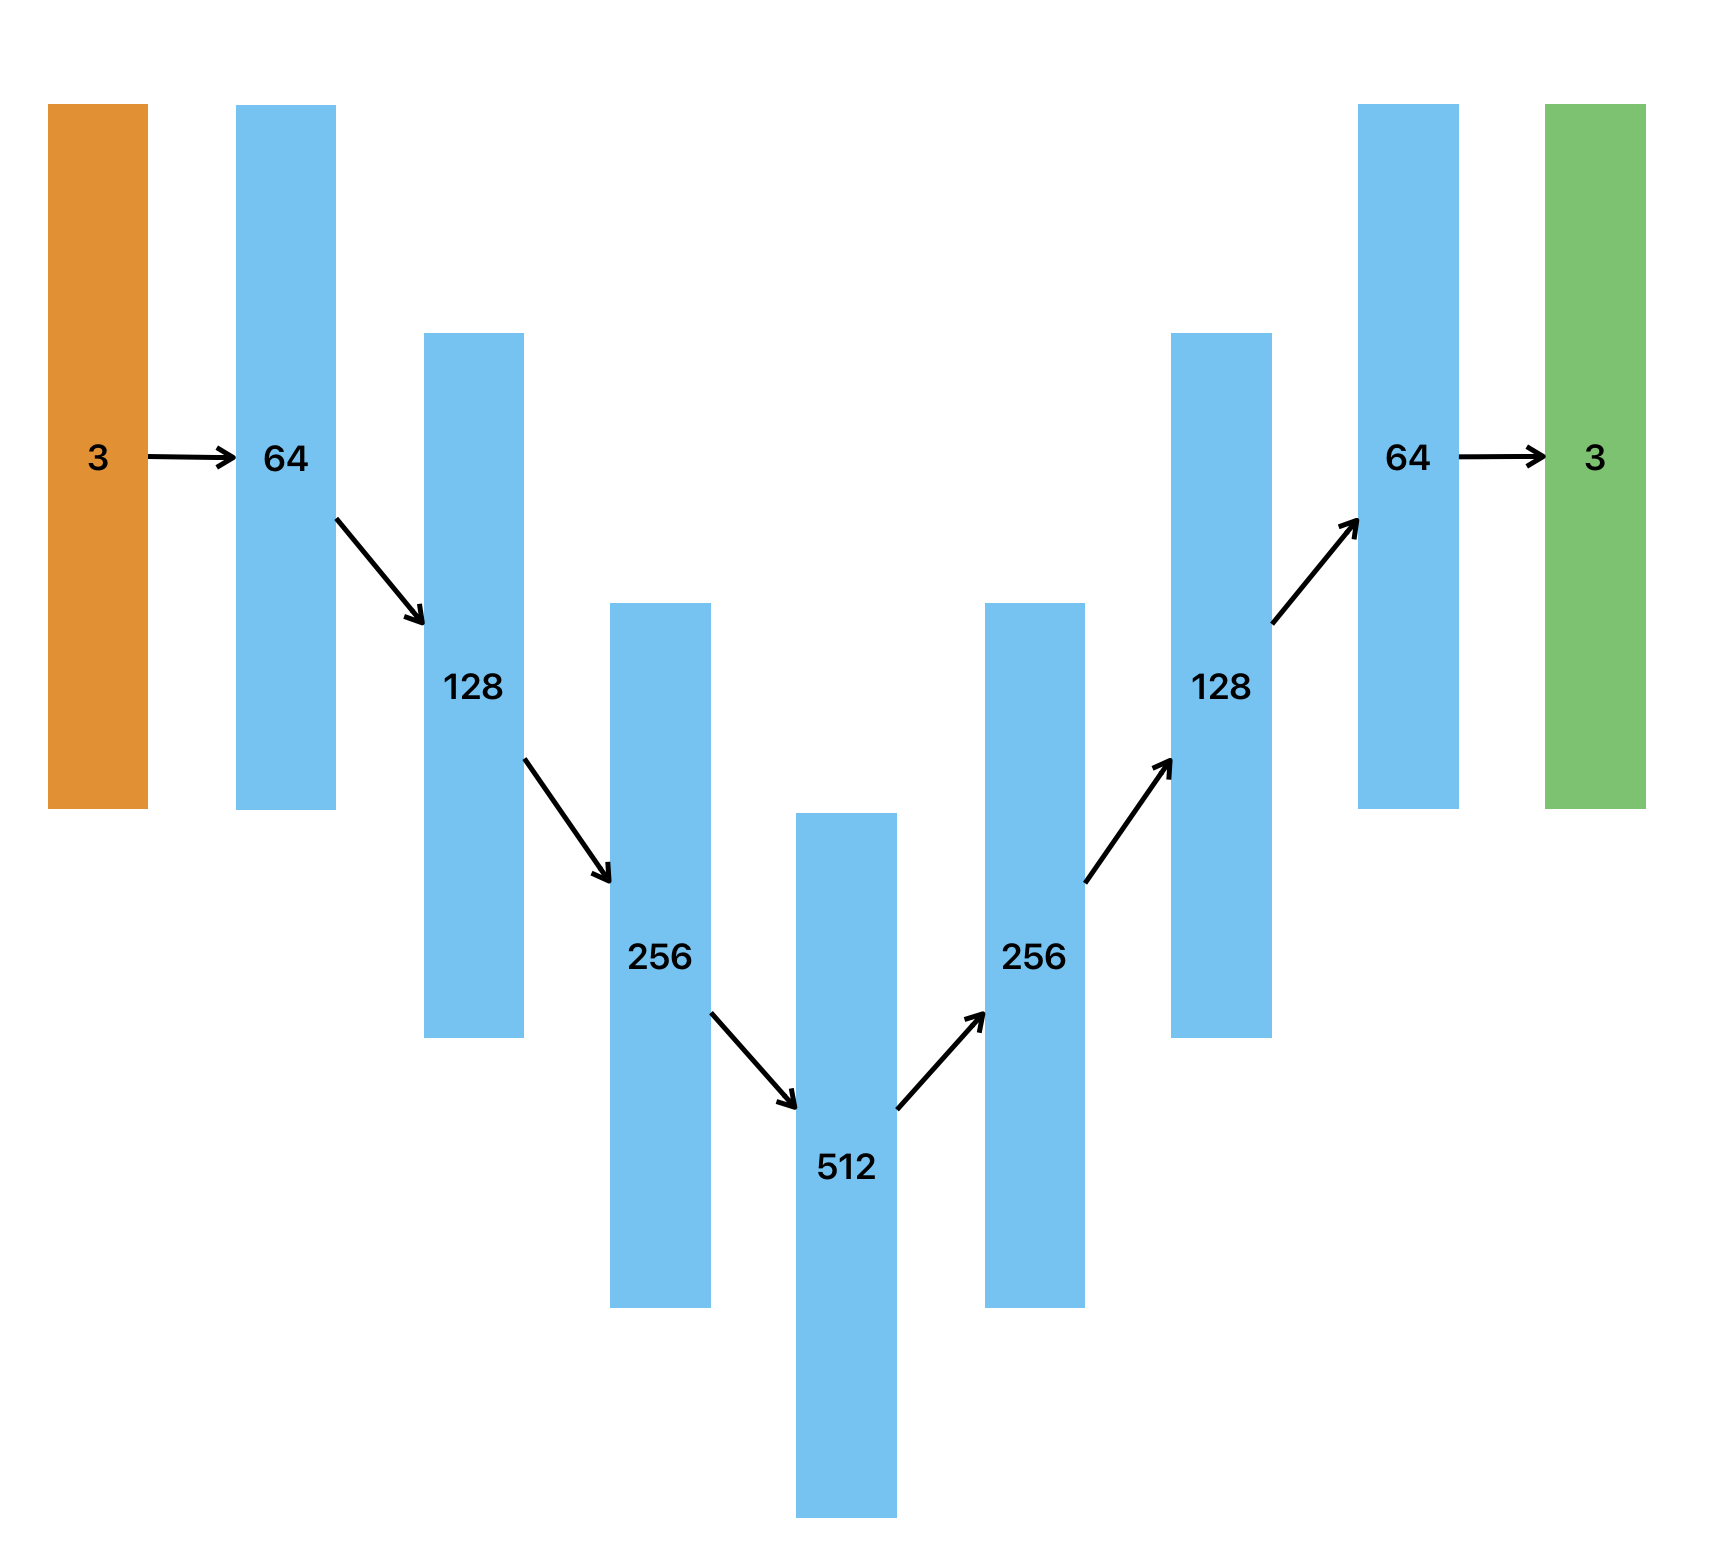

## Importando bibliotecas

certifique-se de conectar com o seu drive para carregar a base de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torchsummary import summary

## Carregando a base de dados

A base de dados escolhida são imagens de *Pixelarts* de tamanho 16x16. Elas estão disponíveis em:
- [Comidas](https://zrghr.itch.io/froots-and-veggies-culinary-pixels)
- [Itens de jogos](https://kyrise.itch.io/kyrises-free-16x16-rpg-icon-pack)

carregamos um arquivo com 89400 itens, com o formato 16x16x3, onde 3 representa as três cores do padrão RGB, indicando que é uma imagem colorida

In [3]:
vetores = np.load('/content/drive/MyDrive/Senior/Python Brasil 2023/sprites_1788_16x16.npy')
vetores.shape

(89400, 16, 16, 3)

In [4]:
tensor = torch.from_numpy(vetores) # transforma em tensor
dataset = torch.utils.data.TensorDataset(tensor) # transforma em um dataset no padrão Pytorch

Agora vamos visualizar alguns itens desse dataset

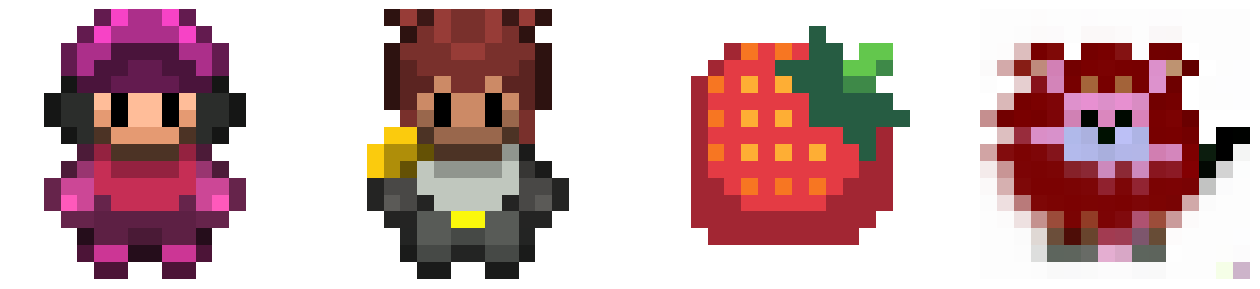

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, enum in enumerate(range(0, 400, 100)):
  # plotando os personagens 0, 100, 200 e 300
  axs[i].imshow(dataset[enum][0])
  axs[i].set_axis_off()
fig.show()

Vamos precisar arrumar nossa base de dados para o treinamento, para isso, vamos criar uma nova classe de Dataset

In [6]:
class PixelDataset(torch.utils.data.dataset.TensorDataset):
    def __init__(self, data, transforms = None):
        self.samples = data
        self.transforms= transforms

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

Precisamos criar também um vetor de transforms, que vão manipular nossos dados e deixá-los do formato que precisamos

In [7]:
tf = transforms.Compose([
        transforms.ToTensor(), # Tranforma em um tensor e escala para [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1), # escala os valores para [-1, 1]
    ])

... e vamos iniciar nosso dataset

In [8]:
dataset_tranformers = PixelDataset(vetores, tf)
dataset_tranformers.__len__()

89400

## Treinando o modelo

### DDPM Schedules
função que pré-calcula todos os pesos e valores necessários para gerar e prever o ruído das imagens, ela necessita de três parâmetros: Beta_1, Beta_2 e T.

Vamos utilizar como parâmetros de treinamento o que foi sugerido no artigo [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf):
- Beta_1 = 0.0001
- Beta_2 = 0.02

In [9]:
def ddpm_schedules(T: int):
    beta1 = 0.0001
    beta2 = 0.02

    # cria um vetor de beta1 até beta2, com T+1 valores (de 0 até 1000) espaçados linearmente entre si
    # ou seja, são todos os nossos valores de noise para adicionar a cada passo na imagem
    beta_t = torch.linspace(start=beta1, end=beta2, steps=T+1)

    # valores pré-calculados para que possamos calcular a versão com ruído de uma imagem
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp() # soma acumulativa do log de alpha_t

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

### DDPM
classe principal dos modelos de difusão, é ela que vai calcular o ruído para ser adicionado no Foward Process e vai gerar novas imagens removendo o ruído no Backward Process. Vamos ter então as seguintes funções:
- __init__: cria o modelo, recebe de parâmetro uma UNet, o valor de T e o função de erro (MSELoss).
- **foward**: recebe um tensor (imagem) e a partir dele faz o processo de difusão que insere ruído na imagem e tenta adivinhar o ruído adicionado utilizando a UNet. Como resultado, devolve o erro entre o ruído adicionado e o ruído previsto
- **sample**: função que retira o ruído da imagem para gerar uma nova figura. Ela deve gerar uma imagem com ruído, prever o ruído adicionado nessa imagem com o modelo e remover esse ruído, adicionando um novo ruído aleatório para não dar overfitting no modelo.


In [10]:
class DDPM(nn.Module): # Denoising Diffusion Probabilistic Models (DDPM)
    def __init__(self, eps_model: nn.Module, n_T, criterion: nn.Module = nn.MSELoss()):
        super(DDPM, self).__init__()
        self.eps_model = eps_model
        # registra todos os valores pré-calculados no buffer
        for k, v in ddpm_schedules(n_T).items():
            self.register_buffer(k, v)
        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor):
        # pega um valor aleatório entre 1 e n_T, de uma distribuição uniforme
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(x.device)  # t ~ Uniform(0, n_T)
        # pega um ruído aleatório, de uma distribuição normal
        ruido_adicionado = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            # ps.: a função do None é apenas para manter o formato correto do tensor
            self.sqrtab[_ts, None, None, None] * x # está pegando o valor de sqrtab na posição _ts. * x
            + self.sqrtmab[_ts, None, None, None] * ruido_adicionado  # somando com o valor sqrtmab na posição _ts * eps
        )

        # vamos prever a quantidade de ruído adicionado, e comparar com o ruído previsto para definir o erro.
        return self.criterion(ruido_adicionado, self.eps_model(x_t))

    def sample(self, n_sample: int, size, device):
        # retorna 'n_samples' tensores do tamanho 'size' preenchidos
        # com valores aleatórios de uma distribuição normal
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        for i in range(self.n_T, 0, -1):
            # gera um 'n_samples' tensores
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            # vamos prever a quantidade de ruído adicionados nos tensores x_i
            ruido_previsto = self.eps_model(x_i)
            # transformamos esses tensores aleatórios da seguinte forma:
            # 1. removemos o ruído previsto
            # 2. adicionamos um ruído 'z' para não overfittar
            x_i = (
                self.oneover_sqrta[i] * (x_i - ruido_previsto * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i

### UNet
aqui vamos escrever a UNet que descrevemos no início, ela vai prever o ruído adicionado na imagem

In [11]:
def bloco(canal_input, canal_output):
  bloco = nn.Sequential(
            nn.Conv2d(canal_input, canal_output, kernel_size=7, padding=3),
            nn.BatchNorm2d(canal_output),
            nn.LeakyReLU())
  return bloco

class UnetSimples(nn.Module):
    def __init__(self, n_channel: int):
        super(UnetSimples, self).__init__()
        self.conv = nn.Sequential(
            bloco(n_channel, 64), # down 1
            bloco(64, 128), # down 2
            bloco(128, 256), # down 3
            bloco(256, 512), # down 4
            bloco(512, 256), # up 4
            bloco(256, 128), # up 3
            bloco(128, 64), # up 2
            nn.Conv2d(64, n_channel, 3, padding=1), # up 1 e outuput
        ).to('cuda:0')

    def forward(self, x):
        return self.conv(x)

unet = UnetSimples(3) # temos 3 canais de cores - RGB
summary(unet, (3, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         LeakyReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         401,536
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]       1,605,888
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 512, 16, 16]       6,423,040
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
        LeakyReLU-12          [-1, 512, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]       6,422,784
      BatchNorm2d-14          [-1, 256,

### Treinamento do modelo
Aqui vamos fazer o loop de treinamento do modelo de difusão, iniciamos gerando o modelo DDPM e separando a base de dados em batchs de tamanho 128. Em seguinda iteramos pelo número de épocas definidas, adicionando ruído em uma imagem e prevendo ele, e no final de cada época avaliamos o resultado atingido.

In [12]:
def treina_modelo_difusao(dataset, unet, n_epoch: int = 100, device="cuda:0"):
    # vamos rodar por 1000 iterações, conforme definido no artigo
    ddpm = DDPM(eps_model=unet, n_T=1000)
    ddpm.to(device)

    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
    optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)
    for i in range(n_epoch):
        ddpm.train() # ativa o modo de treinamento
        if i % 5 == 0:
          print(f'Iniciando o treinamento da época {i}...')
        pbar = iter(dataloader)
        loss_ema = None
        for x in pbar:
            optim.zero_grad() # zerando os gradientes
            x = x.to(device)
            loss = ddpm(x) # gera a imagem com ruído
            loss.backward() # calcula os gradientes
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            optim.step() # atualiza os pesos de acordo com os gradientes calculados

        ddpm.eval() # ativa o modo de avaliação
        if i % 5 == 0:
          print(f'---------------- Avaliando época {i} ----------------')
          with torch.no_grad():
              xh = ddpm.sample(16, (3, 16, 16), device) # gera 16 imagens
              grid = make_grid(xh, nrow=4) # transforma numa grid
              plt.imshow((grid.permute(1, 2, 0).cpu().numpy())) #reshape
              plt.show()
              save_image(grid, f"/content/drive/MyDrive/Senior/Python Brasil 2023/resultado/ddpm_sample_{i}.png")

              # salva o modelo
              torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")

Iniciando o treinamento da época 0...
---------------- Avaliado época 0 ----------------


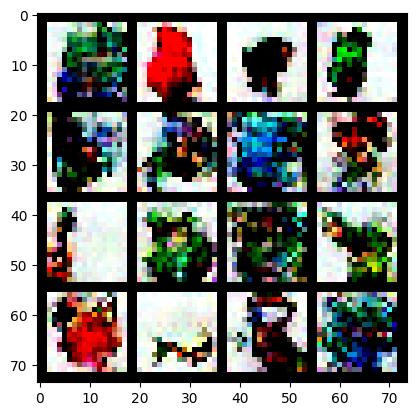

Iniciando o treinamento da época 5...
---------------- Avaliado época 5 ----------------


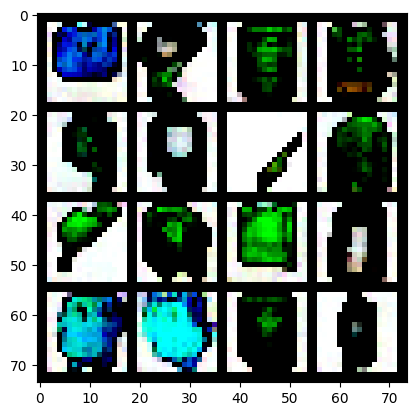

Iniciando o treinamento da época 10...
---------------- Avaliado época 10 ----------------


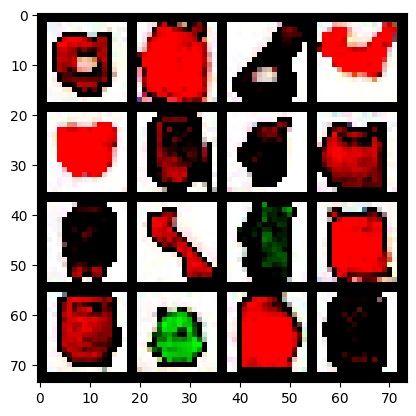

Iniciando o treinamento da época 15...
---------------- Avaliado época 15 ----------------


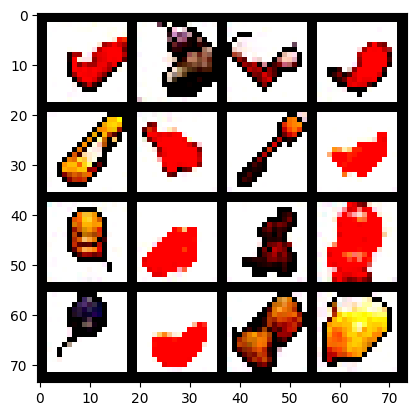

Iniciando o treinamento da época 20...
---------------- Avaliado época 20 ----------------


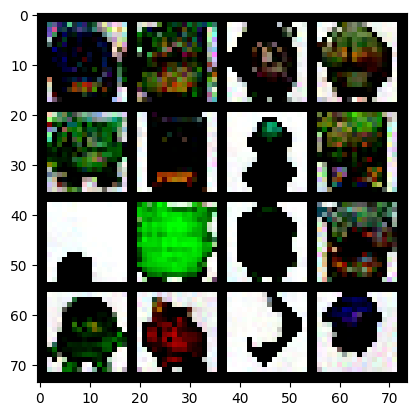

Iniciando o treinamento da época 25...
---------------- Avaliado época 25 ----------------


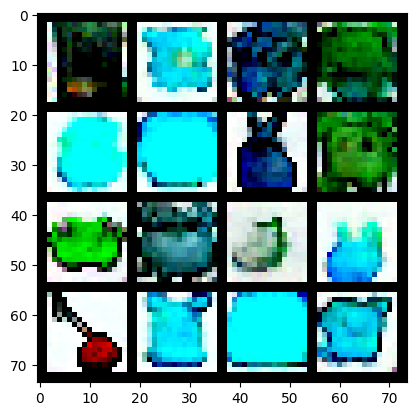

Iniciando o treinamento da época 30...
---------------- Avaliado época 30 ----------------


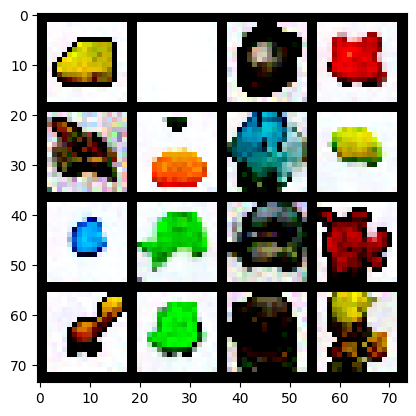

Iniciando o treinamento da época 35...
---------------- Avaliado época 35 ----------------


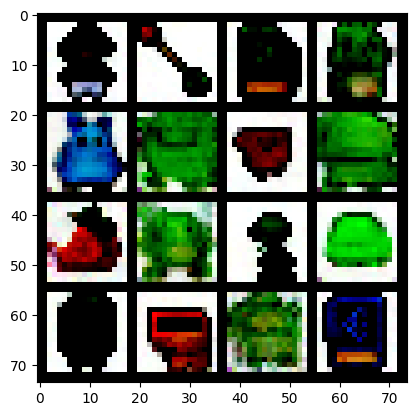

Iniciando o treinamento da época 40...
---------------- Avaliado época 40 ----------------


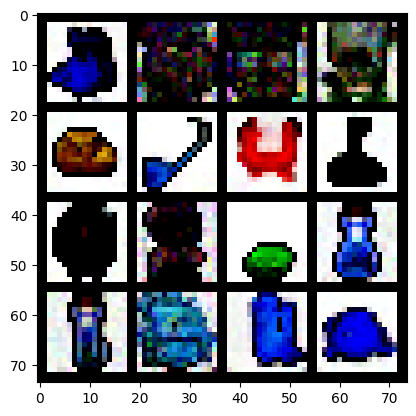

Iniciando o treinamento da época 45...
---------------- Avaliado época 45 ----------------


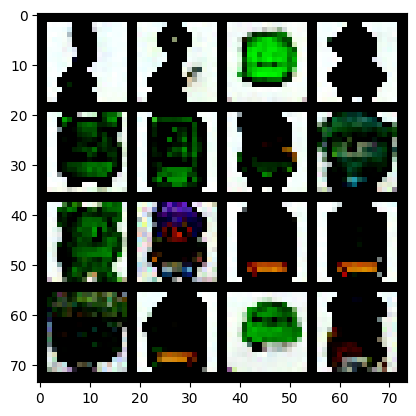

Iniciando o treinamento da época 50...
---------------- Avaliado época 50 ----------------


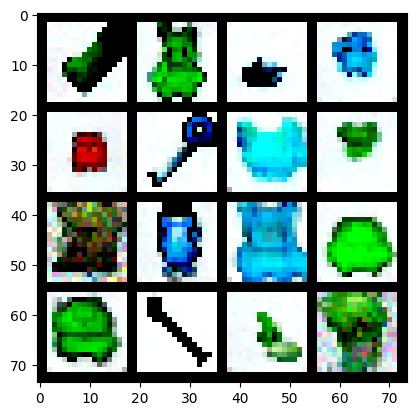

Iniciando o treinamento da época 55...
---------------- Avaliado época 55 ----------------


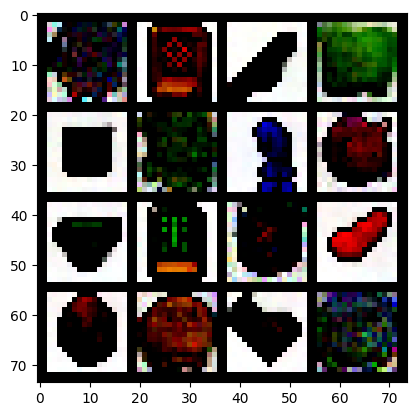

Iniciando o treinamento da época 60...
---------------- Avaliado época 60 ----------------


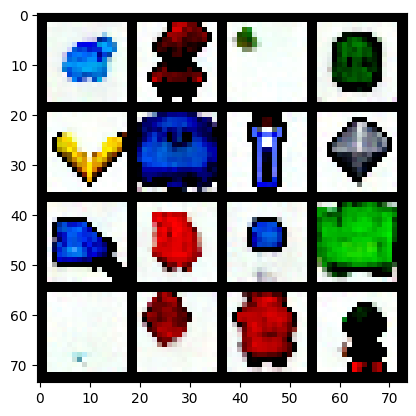

Iniciando o treinamento da época 65...
---------------- Avaliado época 65 ----------------


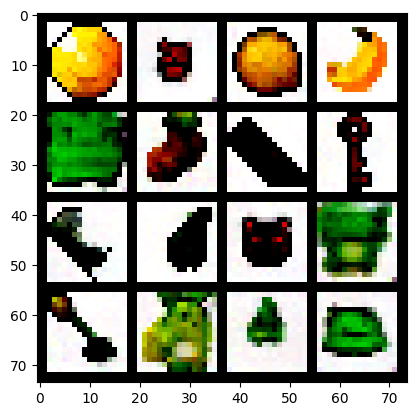

Iniciando o treinamento da época 70...
---------------- Avaliado época 70 ----------------


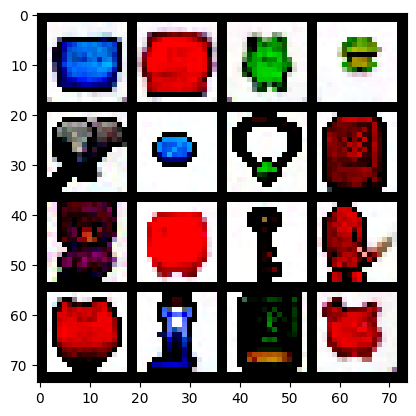

Iniciando o treinamento da época 75...
---------------- Avaliado época 75 ----------------


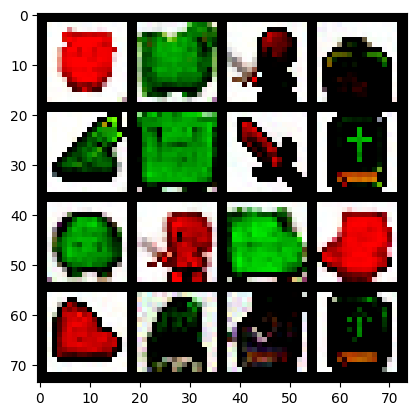

In [ ]:
treina_modelo_difusao(dataset_tranformers, unet)

## Referências
Para a construção desse notebook, foram utilizamos como referência as seguintes fontes:
- [How Diffusion Models Work - DeepLearning.ai](https://www.coursera.org/learn/how-diffusion-models-work-project/home)
- [minDiffusion](https://github.com/cloneofsimo/minDiffusion)
- [Diffusion models from scratch in PyTorch](https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=827s)